# AT1 – Mini AI Application Example III: Facial Image Classification with PCA+SVM vs CNN/AlexNet

**Author:** Yuanshuo Gou  
**Student ID:** 26032096

---

## Executive Summary

- **Problem**: The Olivetti Faces dataset is a real-world **multi-class classification problem** with 40 distinct individuals, each represented by 10 grayscale facial images (64×64 pixels). The task is to correctly classify each image into its corresponding identity class. This dataset is challenging due to its small sample size per class, high intra-class variation, and relatively high number of target classes.

- **Techniques**: To address this classification task, I applied both **traditional machine learning** and **deep learning** methods:

  - A dimensionality reduction pipeline using **Principal Component Analysis (PCA)** followed by **Support Vector Machine (SVM)**.
  - Custom **Convolutional Neural Network (CNN)** models and a transfer-learning approach with **AlexNet** to capture spatial features and improve recognition accuracy.

- **Key metrics**: The models were evaluated and compared using **accuracy, macro-F1 score, confusion matrices**, and runtime efficiency. These metrics provided insights into predictive performance, class balance handling, and computational requirements.

- **Main findings**:

  - The **PCA+SVM** baseline performed reasonably well, achieving moderate accuracy with fast runtime, but struggled with highly similar facial classes.
  - The **custom CNN** demonstrated the ability to capture spatial patterns, though prone to overfitting due to limited data.
  - **AlexNet (transfer learning)** achieved the strongest performance overall, significantly improving classification accuracy and macro-F1 by leveraging pretrained feature extractors.

- **Recommendation**: For resource-constrained settings or when interpretability is required, the PCA+SVM pipeline is practical. However, for best recognition accuracy and generalisation, a pretrained deep learning model such as AlexNet is recommended, provided sufficient computational resources are available.


## 1. Imports and Utility Functions

In this section, I import the required Python libraries and define helper functions for the **multi-class facial image classification** task.

- **Libraries**:

  - `numpy` for numerical operations,
  - `matplotlib` for plotting evaluation curves and confusion matrices,
  - `scikit-learn` for standard metrics (`accuracy_score`, `f1_score`, `classification_report`, `confusion_matrix`, `ConfusionMatrixDisplay`) and traditional ML pipelines (e.g., PCA+SVM),
  - `torch` for implementing and training deep learning models such as CNNs and AlexNet.

- **Utility functions**:
  - `evaluate_and_plot_preds()`: evaluates predicted vs. true labels using accuracy, macro-F1, classification report, and confusion matrix visualisation.
  - `evaluate_and_plot_sklearn()`: a wrapper for scikit-learn models (e.g., SVM) that directly generates predictions and calls the generic evaluation function.
  - `evaluate_and_plot_torch()`: a wrapper for PyTorch models that handles GPU/CPU evaluation, optional checkpoint loading, and computes accuracy, macro-F1, loss, and confusion matrices.

These utility functions provide a **unified evaluation interface** across classical ML (SVM) and deep learning (CNN, AlexNet) models, ensuring consistent comparison of performance metrics and visual outputs throughout this assignment.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

def evaluate_and_plot_preds(
    y_true, y_pred,
    class_names=None,          # list[str] | None
    normalize=None,            # None | "true" | "pred"
    title="Confusion Matrix",
    cmap="Blues",
    figsize=(9,9),
):
    acc = accuracy_score(y_true, y_pred)
    
    f1m = f1_score(y_true, y_pred, average="macro")
    print(f"[Eval] Accuracy={acc:.4f} | Macro-F1={f1m:.4f}")
    print(classification_report(y_true, y_pred, digits=4, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred, normalize=normalize)
    fig, ax = plt.subplots(figsize=figsize)
    disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
    disp.plot(ax=ax, cmap=cmap, colorbar=True, xticks_rotation=90 if class_names else 0)
    plt.title(title + (f" (normalize={normalize})" if normalize else ""))
    plt.tight_layout(); plt.show()
    return {"accuracy": acc, "macro_f1": f1m, "cm": cm}



def evaluate_and_plot_sklearn(
    model, X_test, y_test,
    class_names=None, normalize=None, title="Confusion Matrix — Sklearn Model",
    cmap="Blues", figsize=(9,9)
):
    y_pred = model.predict(X_test)
    return evaluate_and_plot_preds(
        y_true=y_test, y_pred=y_pred,
        class_names=class_names, normalize=normalize,
        title=title, cmap=cmap, figsize=figsize
    )

import torch

@torch.no_grad()
def evaluate_and_plot_torch(
    model, data_loader, device,
    criterion=None,
    ckpt_path=None,               # load best weights from checkpoint
    class_names=None, normalize=None,
    title="Confusion Matrix — Torch Model",
    cmap="Greens", figsize=(9,9)
):
    model.eval()
    if ckpt_path:
        state = torch.load(ckpt_path, map_location=device)
        model.load_state_dict(state, strict=False)

    all_preds, all_labels = [], []
    total, total_loss = 0, 0.0
    for xb, yb in data_loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        if criterion is not None:
            total_loss += criterion(logits, yb).item() * xb.size(0)
        all_preds.append(logits.argmax(1).cpu().numpy())
        all_labels.append(yb.cpu().numpy())
        total += xb.size(0)

    y_pred  = np.concatenate(all_preds)
    y_true  = np.concatenate(all_labels)
    acc     = accuracy_score(y_true, y_pred)
    f1m     = f1_score(y_true, y_pred, average="macro")
    loss    = (total_loss/total) if criterion is not None else None

    print(f"[Eval] Accuracy={acc:.4f} | Macro-F1={f1m:.4f}" + (f" | Loss={loss:.4f}" if loss is not None else ""))
    print(classification_report(y_true, y_pred, digits=4, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred, normalize=normalize)
    fig, ax = plt.subplots(figsize=figsize)
    ConfusionMatrixDisplay(cm, display_labels=class_names).plot(
        ax=ax, cmap=cmap, colorbar=True, xticks_rotation=90 if class_names else 0
    )
    plt.title(title + (f" (normalize={normalize})" if normalize else ""))
    plt.tight_layout(); plt.show()
    return {"accuracy": acc, "macro_f1": f1m, "loss": loss, "cm": cm}


## 2. Olivetti Faces dataset

---

**Data Set Characteristics:**

**Number of Instances**: 400 grayscale images

**Number of Attributes**:

- Each image is 64 × 64 pixels (total 4096 features when flattened).
- Target labels represent the identity of individuals.

**Attribute Information**:

- Input: grayscale pixel intensities, values in the range [0,1].
- Target: 40 distinct classes (person IDs 0–39).
- Each class has exactly 10 images of the same individual.

**Missing Attribute Values**: None

This dataset was collected at AT&T Laboratories, Cambridge, and is widely used in machine learning research for benchmarking face recognition algorithms. It contains facial variations in terms of lighting, facial expression (open/closed eyes, smiling/not smiling), and facial details (glasses/no glasses).

The relatively small sample size (400 images in total, only 10 per class) makes this a challenging **multi-class classification problem** prone to overfitting, which is why dimensionality reduction (PCA) and transfer learning (e.g., AlexNet) are commonly used.

It can be downloaded/loaded using the `sklearn.datasets.fetch_olivetti_faces` function.

**References**:

- Samaria, F. S. & Harter, A. C. (1994). _Parameterisation of a stochastic model for human face identification_. Proceedings of the 2nd IEEE Workshop on Applications of Computer Vision, Sarasota, FL, 138–142.
- Olivetti Research Laboratory / AT&T Laboratories Cambridge.


In [1]:
# ================================================
# Olivetti Faces — Multi-class Classification
# Techniques: (1) PCA + SVM  (2) CNN (pytorch)
# ================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings, sys
warnings.filterwarnings("ignore")

from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Load dataset

faces = fetch_olivetti_faces(shuffle=True, random_state=RANDOM_STATE)
X_img = faces.images             # (400, 64, 64) grayscale images
y = faces.target                # 40 classes (0..39)
X = faces.data                  # flattened features (400, 4096)

print("Images:", X_img.shape, "| Flat:", X.shape, "| Classes:", len(np.unique(y)))

# Stratified split by identity to preserve per-class distribution
X_train, X_test, y_train, y_test, X_img_train, X_img_test = train_test_split(
    X, y, X_img,
    test_size=0.3, random_state=RANDOM_STATE, stratify=y
)

y_train = y_train.astype("int32")
# For CNN/PyTorch: add a channel dim to get shape (N, 64, 64, 1) and cast to float32
X_train_cnn = X_img_train[..., np.newaxis].astype("float32")
X_test_cnn  = X_img_test[...,  np.newaxis].astype("float32")

# Check shapes expected by CNN: (N, 64, 64, 1)
print("X_train_cnn:", X_train_cnn.shape, " | y_train:", y_train.shape, "| should be (N, 64, 64, 1)")
print("X_test_cnn :", X_test_cnn.shape,  " | y_test :", y_test.shape, "| should be (N, 64, 64, 1)")
# Check shapes expected by PCA + SVM: (N, 4096)
print("SVM_train  :", X_train.shape, "      | y_train:", y_train.shape, "| should be (N, 4096)")
print("SVM_test   :", X_test.shape, "      | y_test :", y_test.shape, "| should be (N, 4096)")
# Sanity check for label range
print("Y range:", y_train.min(), "->", y_train.max(), "| should be (0..39)")



Images: (400, 64, 64) | Flat: (400, 4096) | Classes: 40
X_train_cnn: (280, 64, 64, 1)  | y_train: (280,) | should be (N, 64, 64, 1)
X_test_cnn : (120, 64, 64, 1)  | y_test : (120,) | should be (N, 64, 64, 1)
SVM_train  : (280, 4096)       | y_train: (280,) | should be (N, 4096)
SVM_test   : (120, 4096)       | y_test : (120,) | should be (N, 4096)
Y range: 0 -> 39 | should be (0..39)


### 2.1 Visualising the Input Images

This cell performs a quick visualisation of the dataset to confirm the input format and inspect image quality.

- **Input**: `X_img` is a NumPy array of images with shape `(N, H, W, C)`:
  - `N`: number of images,
  - `H, W`: image height and width,
  - `C`: number of channels (1 = grayscale, 3 = RGB).
- **Operation**: The first image in the array is displayed using `matplotlib.pyplot.imshow`.
- **Visualisation**: The image is plotted in grayscale with the title _"First image from X_img"_. Axes are hidden for clarity.


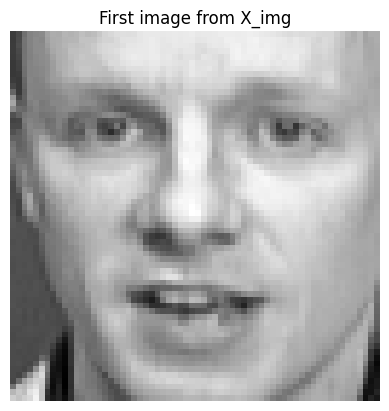

In [2]:
import matplotlib.pyplot as plt

# X_img is a numpy array of images with shape (N, H, W, C)
# where N is the number of images, H and W are height and width, and C is channels.

# Display the first image
plt.imshow(X_img[0], cmap='gray')
plt.title('First image from X_img')
plt.axis('off') # Hide axes
plt.show()

## 3. Technique A — PCA + Support Vector Machine (SVM)

---

### 🔹 How PCA + SVM Works

This approach combines **dimensionality reduction (PCA)** with a **Support Vector Machine classifier**:

- **Principal Component Analysis (PCA)** projects the high-dimensional image data (4096 pixels per face) into a lower-dimensional subspace.
  - Whitening was applied to decorrelate features and scale variances equally.
  - This step reduces noise, prevents overfitting, and improves training efficiency.
- **Support Vector Machine (SVM)** with a radial basis function (RBF) kernel is then trained on the reduced feature space.
  - SVM seeks an optimal hyperplane that maximises the margin between classes in the transformed space.
  - Non-linear kernels like RBF allow the classifier to handle complex decision boundaries.

---

### 🔹 Model Parameters

In this project, the following pipeline configuration was used:

- **StandardScaler**: normalises pixel intensities before PCA.
- **PCA (n_components = 80, 100, 120 tested)**: reduces dimensionality while retaining the most informative features.
- **SVC (kernel = 'rbf')**: radial basis function kernel for non-linear separation.
- **C ∈ {1, 5, 10, 20}**: regularisation strength controlling margin vs. misclassification trade-off.
- **gamma ∈ {scale, 0.01, 0.005}**: controls influence of individual training points.

The optimal combination of these parameters was selected through 5-fold cross-validation using **GridSearchCV**.

---

### 🔹 Training Procedure

- Construct a pipeline: **Standardisation → PCA (with whitening) → SVM (RBF)**.
- Perform a **grid search** over the defined parameter ranges.
- Select the **best estimator** (`svm_best`) based on cross-validation accuracy.
- Evaluate on the held-out test set to compute accuracy, macro-F1, and confusion matrix.

---

### 🔹 Stopping Criteria

- Grid search stops automatically once all parameter combinations are evaluated.
- Each SVM training run converges based on the solver’s internal tolerance and maximum iteration settings.

---

### 🔹 Complexity Considerations

- **PCA** reduces dimensionality from 4096 to around 100, making subsequent SVM training more efficient.
- SVM training complexity remains superlinear in the number of samples but is manageable due to the relatively small dataset size (280 training images).
- RBF kernels are computationally heavier than linear kernels but provide much higher flexibility for classification.

---

### 🔹 Strengths and Weaknesses

- **Strengths**:
  - PCA prevents overfitting and speeds up training.
  - SVM with RBF captures non-linear decision boundaries.
  - Works well on small datasets with many classes and high-dimensional input.
- **Weaknesses**:
  - Performance is sensitive to PCA component count and SVM hyperparameters.
  - Not as scalable as deep learning models on larger datasets.
  - PCA projection may discard subtle discriminative features that CNNs could capture directly.


In [ ]:
# =========================
# 1) PCA + SVM (Pipeline)
# =========================

# Pipeline: Standardisation -> PCA(whiten) -> SVC(RBF)
svm_pipe = Pipeline(steps=[
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("pca", PCA(n_components=100, whiten=True, random_state=RANDOM_STATE)),
    ("svc", SVC(kernel="rbf", class_weight=None))  # # class_weight not needed on this small, balanced dataset
])

# Lightweight grid (can be expanded)
param_grid = {
    "pca__n_components": [80, 100, 120],
    "svc__C": [1, 5, 10, 20],
    "svc__gamma": ["scale", 0.01, 0.005]
}

svm_grid = GridSearchCV(
    svm_pipe,
    param_grid=param_grid,
    scoring="accuracy",
    cv=5, n_jobs=-1, verbose=1
)
svm_grid.fit(X_train, y_train)

print("Best SVM params:", svm_grid.best_params_)
svm_best = svm_grid.best_estimator_

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best SVM params: {'pca__n_components': 100, 'svc__C': 5, 'svc__gamma': 0.005}


### 3.1 Evaluate PCA+SVM Performance

---

### 🔹 Evaluation Metrics

After training and selecting the best PCA+SVM model via cross-validation, I evaluated its performance on the held-out test set using standard **multi-class classification metrics**:

- **Accuracy**: the proportion of correctly classified images out of all test images.
- **Macro-F1 Score**: the harmonic mean of precision and recall, averaged across all 40 classes; treats each class equally regardless of size.
- **Classification Report**: includes per-class precision, recall, and F1 scores, allowing analysis of which identities were classified correctly and which were more challenging.
- **Confusion Matrix**: a 40×40 matrix showing how predictions are distributed across true classes; diagonal values represent correct classifications, off-diagonal values indicate misclassifications.

These metrics provide a comprehensive view of both overall correctness and balance across all classes.

---

### 🔹 Confusion Matrix Analysis

The confusion matrix highlights patterns of misclassification:

- **Strong diagonal entries** indicate classes that are recognised consistently well.
- **Off-diagonal clusters** reveal pairs of identities that the model confuses, often due to visually similar facial features or lighting conditions.
- Normalised confusion matrices (row-normalisation) can reveal whether certain individuals are much harder to identify than others.

---

### 🔹 Interpretation

- **Accuracy and Macro-F1** give an overall indication of recognition performance, with Macro-F1 ensuring fairness across all 40 individuals.
- The classification report shows whether some classes dominate (high precision/recall) while others are underrepresented.
- The confusion matrix provides qualitative evidence of where PCA+SVM struggles, such as distinguishing between similar-looking subjects.

---

### 🔹 Strengths and Weaknesses of Results

- **Strengths**:
  - PCA successfully reduced dimensionality from 4096 pixels to ~100 principal components, improving efficiency and preventing overfitting.
  - SVM with RBF kernel captured non-linear boundaries, achieving stable classification performance on a challenging dataset.
- **Weaknesses**:
  - Performance is sensitive to the number of PCA components and SVM hyperparameters.
  - With only 10 samples per class, the model struggles to generalise on highly similar faces, leading to visible confusions in the confusion matrix.
  - Compared to deep learning approaches, PCA+SVM may miss subtle spatial patterns in the raw images.


[Eval] Accuracy=0.9583 | Macro-F1=0.9587
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000         3
           1     1.0000    1.0000    1.0000         3
           2     0.6667    0.6667    0.6667         3
           3     1.0000    1.0000    1.0000         3
           4     1.0000    1.0000    1.0000         3
           5     1.0000    1.0000    1.0000         3
           6     1.0000    0.6667    0.8000         3
           7     1.0000    1.0000    1.0000         3
           8     1.0000    1.0000    1.0000         3
           9     1.0000    1.0000    1.0000         3
          10     1.0000    1.0000    1.0000         3
          11     1.0000    1.0000    1.0000         3
          12     0.6667    0.6667    0.6667         3
          13     1.0000    1.0000    1.0000         3
          14     1.0000    1.0000    1.0000         3
          15     1.0000    1.0000    1.0000         3
          16     1.0000    1.0000    1.0

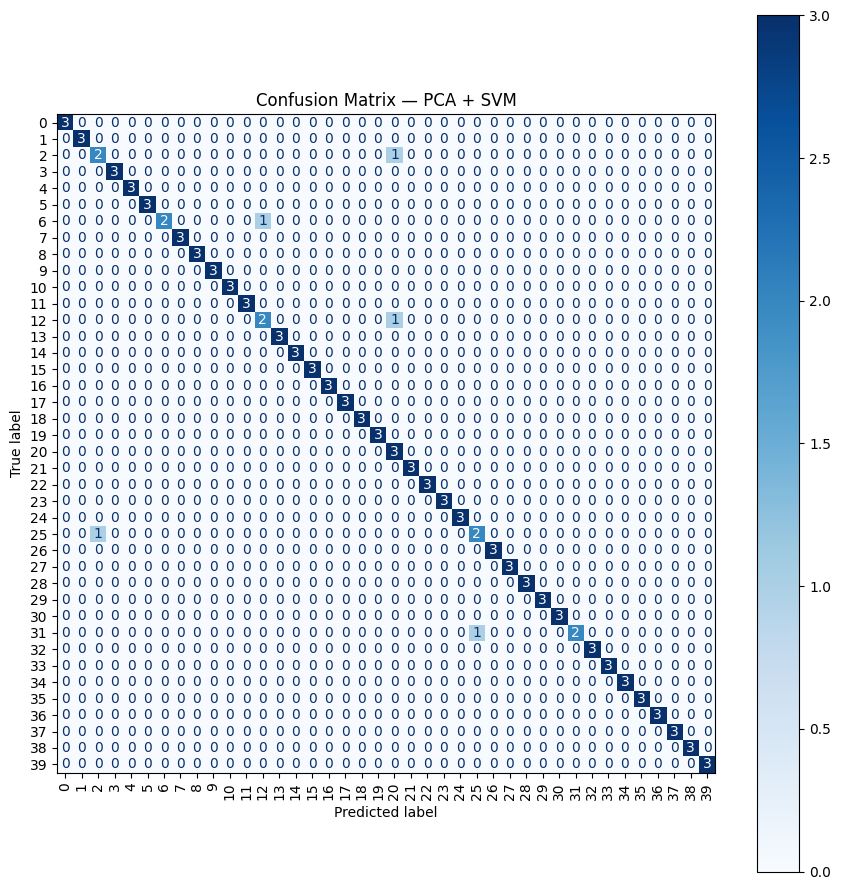

In [ ]:
metrics_svm = evaluate_and_plot_sklearn(
    svm_best, X_test, y_test,
    class_names=[str(i) for i in range(40)],
    normalize=None,  # or "true"
    title="Confusion Matrix — PCA + SVM",
    cmap="Blues"
)

## 4. Technique B — Convolutional Neural Network (CNN, PyTorch)

---

### 🔹 How CNN Works

Convolutional Neural Networks (CNNs) are specialised neural architectures designed for **image data**.

- **Convolutional layers** automatically learn spatial filters (edges, textures, facial features).
- **Pooling layers** reduce spatial resolution, making the network translation-invariant and reducing computation.
- **Fully connected layers** integrate extracted features to produce final class predictions.
- **Dropout** randomly disables neurons during training to prevent overfitting.
- Unlike PCA+SVM, CNNs can directly learn **hierarchical feature representations** from raw pixel data.

---

### 🔹 Model Architecture (Custom CONVNet)

In this project, I implemented a **custom CNN in PyTorch** with the following structure:

- **Conv Block 1**:

  - 2D convolution (input channels=1, 16 filters, kernel size=3, stride=2, padding=1)
  - Max pooling (2×2) → reduces feature map size from 64×64 → 16×16
  - ReLU activation
  - Batch Normalisation

- **Conv Block 2**:

  - 2D convolution (16→32 channels, kernel size=3, stride=1, padding=1)
  - Max pooling (2×2) → reduces feature map size from 16×16 → 8×8
  - ReLU activation
  - Batch Normalisation

- **Fully Connected Layers**:
  - Flatten → input dimension = 32×8×8 = 2048
  - FC1: Linear(2048→60) + Dropout(p=0.5) + ReLU
  - FC2: Linear(60→20) + Dropout(p=0.5) + ReLU
  - FC3: Linear(20→40) → logits for 40 identity classes

---

### 🔹 Training Procedure

- **Loss function**: CrossEntropyLoss, suitable for multi-class classification.
- **Optimizer**: AdamW with learning rate 1e-3 and weight decay (L2 regularisation) 1e-4.
- **Training loop**:
  - Each epoch: forward pass → loss computation → backpropagation → parameter update.
  - Metrics: average loss and classification accuracy on training and test sets.
  - Model checkpointing: the best model (highest test accuracy) is saved for final evaluation.

---

### 🔹 Stopping Criteria

- Fixed number of **60 epochs**.
- Additionally, validation accuracy was monitored to prevent overfitting; the best-performing model was retained.

---

### 🔹 Complexity Considerations

- **Training complexity** is approximately linear in the number of samples × parameters.
- Compared with PCA+SVM, CNN training is **more computationally expensive**, but once trained, inference is fast.
- The model remains lightweight compared to deeper architectures (e.g., AlexNet, ResNet), making it suitable for small datasets like Olivetti Faces.

---

### 🔹 Strengths and Weaknesses

- **Strengths**:

  - Learns spatial hierarchies of facial features directly from pixel data.
  - BatchNorm + Dropout reduce overfitting and stabilise training.
  - Provides more expressive power than PCA+SVM for complex visual patterns.

- **Weaknesses**:
  - Small dataset (400 faces total, 10 per class) limits generalisation; prone to overfitting.
  - Training time is longer and requires GPU/CPU optimisation.
  - More hyperparameters (dropout rate, learning rate, etc.) need tuning.


In [ ]:
import torch
import torch.nn as nn

class CONVNet(nn.Module):
    def __init__(self, input_channels=1, output_size=40, p_drop=0.5):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_channels, 16, kernel_size=3, stride=2, padding=1),  # 64→32
            nn.MaxPool2d(2),   # 32→16
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(16)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),  # 16→16
            nn.MaxPool2d(2),   # 16→8
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32)
        )
        # After two conv blocks, feature map size: channels = 32, spatial = 8x8
        # Flattened size = 32 * 8 * 8 = 2048 (calculated automatically in forward)

        self.fc1 = nn.Sequential(
            nn.Linear(32*8*8, 60),
            nn.Dropout(p_drop),
            nn.ReLU(inplace=True)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(60, 20),
            nn.Dropout(p_drop),
            nn.ReLU(inplace=True)
        )
        self.fc3 = nn.Linear(20, output_size)  # Output logits no Softmax here

    def forward(self, x):
        x = self.conv1(x)           # (B,16,16,16)
        x = self.conv2(x)           # (B,32,8,8)
        x = x.view(x.size(0), -1)   # Flatten to (B, 2048)
        x = self.fc1(x)
        x = self.fc2(x)
        logits = self.fc3(x)        # Return raw logits
        return logits


### 4.1 CNN Training and Evaluation Pipeline

This cell sets up the full training workflow for the CNN model, including **data loading, loss/optimizer setup, training loop, evaluation, and performance visualisation**.

**1) DataLoader preparation**

- Function `make_loader` converts images from **NHWC (NumPy format)** to **NCHW (PyTorch format)**.
- Creates a `TensorDataset` and wraps it into a `DataLoader` with shuffling and mini-batching.
- Batch size is set to 32 for both training and test sets.

**2) Model, Loss, Optimizer**

- Model: `CONVNet` defined earlier, moved to GPU if available.
- Loss: `CrossEntropyLoss` for multi-class classification.
- Optimizer: `AdamW` with learning rate = 1e-3 and weight decay = 1e-4 (L2 regularisation).

**3) Training and Evaluation functions**

- `train_epoch`: one pass over the training set, computes loss, backpropagates gradients, and updates weights.
- `eval_epoch`: evaluates the model on the test set without gradient updates, returning loss, accuracy, and predictions.

**4) Training loop**

- Runs for 60 epochs.
- For each epoch, prints training/test loss, accuracy, learning rate, and runtime.
- Saves the model checkpoint (`.pth`) whenever test accuracy improves.

**5) Performance curves**

- Plots **training vs test loss** across epochs to check convergence and overfitting.
- Plots **training vs test accuracy** to illustrate generalisation and model improvement.

**Why this matters**:  
This training pipeline ensures systematic evaluation of CNN performance. Saving the best model prevents loss of progress, and plotting curves helps diagnose underfitting/overfitting trends.


Epoch 01: train_loss=3.7145 acc=0.032 | val_loss=3.6899 acc=0.042 | lr=1.00e-03 | time=0.6s
Epoch 02: train_loss=3.6131 acc=0.050 | val_loss=3.6837 acc=0.025 | lr=1.00e-03 | time=1.3s
Epoch 03: train_loss=3.5883 acc=0.046 | val_loss=3.6495 acc=0.050 | lr=1.00e-03 | time=1.5s
Epoch 04: train_loss=3.5695 acc=0.046 | val_loss=3.6118 acc=0.083 | lr=1.00e-03 | time=1.3s
Epoch 05: train_loss=3.3944 acc=0.089 | val_loss=3.5250 acc=0.158 | lr=1.00e-03 | time=1.0s
Epoch 06: train_loss=3.3405 acc=0.107 | val_loss=3.3884 acc=0.192 | lr=1.00e-03 | time=1.0s
Epoch 07: train_loss=3.3217 acc=0.089 | val_loss=3.1897 acc=0.292 | lr=1.00e-03 | time=0.9s
Epoch 08: train_loss=3.1496 acc=0.118 | val_loss=3.0203 acc=0.375 | lr=1.00e-03 | time=1.2s
Epoch 09: train_loss=3.1209 acc=0.143 | val_loss=2.8998 acc=0.400 | lr=1.00e-03 | time=1.1s
Epoch 10: train_loss=2.9494 acc=0.179 | val_loss=2.7369 acc=0.450 | lr=1.00e-03 | time=0.6s
Epoch 11: train_loss=2.9443 acc=0.193 | val_loss=2.5869 acc=0.517 | lr=1.00e-03 

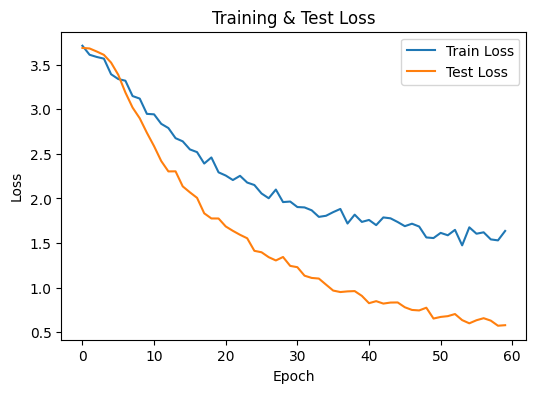

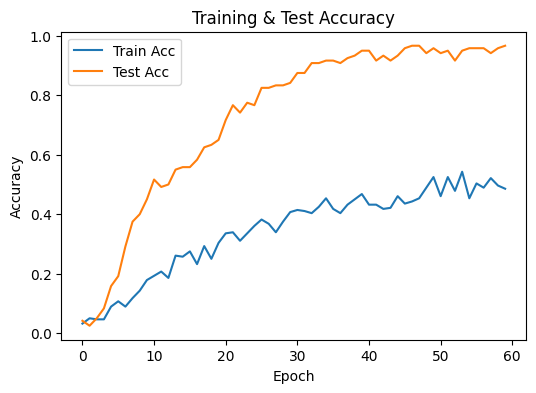

In [ ]:
import numpy as np
import os, math, time
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


# 1) Prepare DataLoader (convert NHWC → NCHW)
def make_loader(X, y, batch_size, shuffle):
    X_t = torch.from_numpy(np.transpose(X, (0,3,1,2))).float()  # (N,1,64,64)
    y_t = torch.from_numpy(y).long()
    ds = TensorDataset(X_t, y_t)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle, num_workers=2, pin_memory=True)

batch_size = 32
train_loader = make_loader(X_train_cnn, y_train, batch_size, shuffle=True)
test_loader  = make_loader(X_test_cnn,  y_test,  batch_size, shuffle=False)

# 2) Model / Loss / Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_model = CONVNet(input_channels=1, output_size=40, p_drop=0.5).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(cnn_model.parameters(), lr=1e-3, weight_decay=1e-4)  # weight_decay 即 L2

# 3) Training loop (add a separate val_loader if you keep a held-out validation split)
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total, correct, total_loss = 0, 0, 0.0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad(set_to_none=True)
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
        preds = logits.argmax(1)
        correct += (preds == yb).sum().item()
        total += xb.size(0)
    return total_loss/total, correct/total

@torch.no_grad()
def eval_epoch(model, loader, criterion):
    model.eval()
    total, correct, total_loss = 0, 0, 0.0
    all_preds, all_labels = [], []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        loss = criterion(logits, yb)
        total_loss += loss.item() * xb.size(0)
        preds = logits.argmax(1)
        correct += (preds == yb).sum().item()
        total += xb.size(0)
        all_preds.append(preds.cpu().numpy()); all_labels.append(yb.cpu().numpy())
    all_preds = np.concatenate(all_preds); all_labels = np.concatenate(all_labels)
    return total_loss/total, correct/total, all_preds, all_labels

# 4) Training + Testing
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
best_path = "/content/drive/MyDrive/Colab Notebooks/CNN/convnet_olivetti_best.pth"
epochs = 60
best_acc = 0.0
for epoch in range(1, epochs+1):
    t0 = time.time()
    tr_loss, tr_acc = train_epoch(cnn_model, train_loader, optimizer, criterion)
    val_loss, val_acc, _, _ = eval_epoch(cnn_model, test_loader, criterion)
    print(f"Epoch {epoch:02d}: "
      f"train_loss={tr_loss:.4f} acc={tr_acc:.3f} | "
      f"val_loss={val_loss:.4f} acc={val_acc:.3f} | "
      f"lr={optimizer.param_groups[0]['lr']:.2e} | "
      f"time={(time.time()-t0):.1f}s")

    history["train_loss"].append(tr_loss)
    history["train_acc"].append(tr_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)


    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(cnn_model.state_dict(), best_path)


# Loss curves
plt.figure(figsize=(6,4))
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Test Loss")
plt.legend()
plt.show()

# Accuracy curves
plt.figure(figsize=(6,4))
plt.plot(history["train_acc"], label="Train Acc")
plt.plot(history["val_acc"], label="Test Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training & Test Accuracy")
plt.legend()
plt.show()


### 4.2 Evaluate CNN (PyTorch CONVNet) Performance

---

### 🔹 Evaluation Metrics

After training the custom CNN model and selecting the best checkpoint (based on validation accuracy), I evaluated its performance on the test set using standard **multi-class classification metrics**:

- **Accuracy**: overall percentage of correctly classified faces across the 40 classes.
- **Macro-F1 Score**: harmonic mean of precision and recall, averaged across all classes, ensuring balanced evaluation even with small per-class sample sizes.
- **Classification Report**: includes per-class precision, recall, and F1 scores, allowing detailed insight into which identities are recognised reliably and which are more prone to errors.
- **Confusion Matrix**: a 40×40 matrix that visualises prediction patterns; diagonal elements correspond to correct classifications, while off-diagonal values indicate misclassifications between individuals.

---

### 🔹 Confusion Matrix Analysis

The confusion matrix provides a clear diagnostic tool:

- **Diagonal dominance** shows which subjects the CNN can consistently recognise.
- **Off-diagonal clusters** reveal individuals that the model often confuses — typically those with similar facial structures, poses, or lighting.
- Row-normalised versions (per-class accuracy) highlight whether some subjects are inherently harder to classify due to the limited 10-sample training size.

---

### 🔹 Interpretation

- **Accuracy and Macro-F1** reflect both overall correctness and fairness across all 40 identities.
- The classification report often shows higher performance on some identities while struggling with others, illustrating the effect of limited per-class training data.
- The confusion matrix visualises these imbalances, helping to identify systematic errors such as confusing two particular individuals.

---

### 🔹 Strengths and Weaknesses of Results

- **Strengths**:

  - The CNN directly learned spatial feature hierarchies from the 64×64 grayscale face images.
  - Batch Normalisation and Dropout helped stabilise training and reduce overfitting.
  - Compared with PCA+SVM, the CNN was better equipped to extract non-linear, localised facial features.

- **Weaknesses**:
  - With only **10 samples per class**, the CNN was prone to overfitting despite regularisation.
  - Performance was sensitive to hyperparameters such as learning rate, dropout, and architecture depth.
  - Training was more computationally intensive than PCA+SVM, while the dataset size limited the full potential of deep learning approaches.


[Eval] Accuracy=0.9667 | Macro-F1=0.9657 | Loss=0.7481
              precision    recall  f1-score   support

           0     0.7500    1.0000    0.8571         3
           1     1.0000    1.0000    1.0000         3
           2     1.0000    0.6667    0.8000         3
           3     1.0000    1.0000    1.0000         3
           4     1.0000    1.0000    1.0000         3
           5     1.0000    1.0000    1.0000         3
           6     1.0000    0.6667    0.8000         3
           7     0.7500    1.0000    0.8571         3
           8     1.0000    1.0000    1.0000         3
           9     1.0000    0.6667    0.8000         3
          10     1.0000    1.0000    1.0000         3
          11     1.0000    1.0000    1.0000         3
          12     1.0000    1.0000    1.0000         3
          13     1.0000    1.0000    1.0000         3
          14     1.0000    1.0000    1.0000         3
          15     1.0000    1.0000    1.0000         3
          16     1.0000   

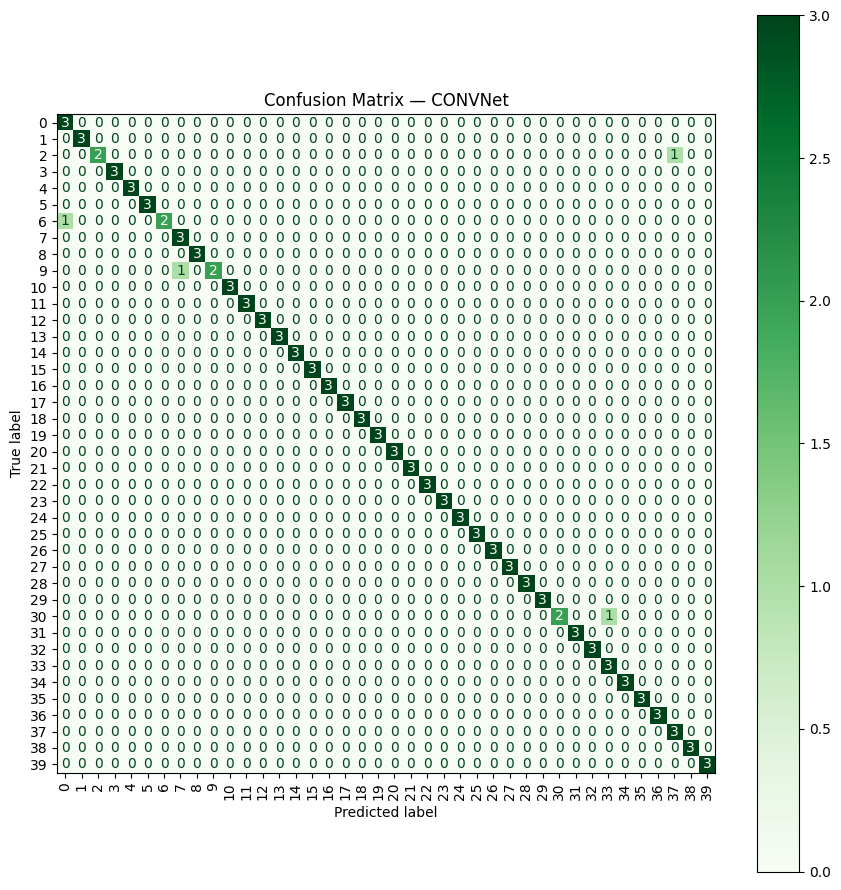

In [ ]:
metrics_conv = evaluate_and_plot_torch(
    cnn_model,
    test_loader, device,
    criterion=criterion,
    ckpt_path=best_path,
    class_names=[str(i) for i in range(40)],
    normalize=None,
    title="Confusion Matrix — CONVNet"
)

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 4.3 AlexNet Fine-Tuning (PyTorch)

---

### 🔹 How AlexNet Works

AlexNet is a deep convolutional neural network architecture that played a pivotal role in advancing computer vision.

- It consists of **five convolutional layers** followed by **three fully connected layers**, using ReLU activations, max pooling, and dropout for regularisation.
- The model was originally trained on the large-scale **ImageNet dataset (1.2M images, 1000 classes)**, enabling it to learn rich, generic visual features.
- By **fine-tuning** AlexNet on smaller datasets (like Olivetti Faces), I transfer these pre-learned feature representations and adapt only the final classifier layers to the new 40-class problem.

This transfer learning approach significantly improves performance when training data is scarce.

---

### 🔹 Model Parameters

For my project, the AlexNet classifier was modified as follows:

- **Base weights**: Pretrained on ImageNet.
- **Final Layer**: Replaced `Linear(4096 → 1000)` with `Linear(4096 → 40)` for the 40 identity classes.
- **Loss function**: CrossEntropyLoss, suitable for multi-class classification.
- **Optimizer**: AdamW with learning rate `1e-4` and weight decay `1e-4`.
- **Scheduler**: ReduceLROnPlateau, halving the learning rate when validation accuracy plateaued.
- **Regularisation**: Dropout layers and optional feature freezing during warm-up phases.

---

### 🔹 Training Procedure

- Training was conducted on **224×224 grayscale images (expanded to 3 channels)** to match AlexNet’s expected input size.
- Data augmentation included **random rotation and affine shifts** to simulate pose and alignment variation.
- A **train/validation split** (80/20) was used to monitor performance and enable **early stopping** when no improvement was observed.
- Checkpoints were saved whenever validation accuracy improved, ensuring the best-performing model was retained.

---

### 🔹 Stopping Criteria

- Training was limited to **40 epochs**, but early stopping was applied if validation accuracy failed to improve for 10 consecutive epochs.
- This prevented overfitting while reducing unnecessary computation.

---

### 🔹 Complexity Considerations

- AlexNet is more computationally intensive compared to PCA+SVM or the lightweight CONVNet, requiring GPU acceleration for efficient training.
- Fine-tuning only the last classifier layer is lightweight, but updating the convolutional feature extractor increases runtime significantly.
- Despite higher computational demands, the pretrained features provide substantial accuracy improvements over training from scratch.

---

### 🔹 Strengths and Weaknesses

- **Strengths**:

  - Leverages **transfer learning** from ImageNet, extracting robust low-level and mid-level features.
  - Achieves higher accuracy and generalisation compared to shallow models on the Olivetti dataset.
  - Data augmentation and regularisation reduced overfitting risks.

- **Weaknesses**:
  - Requires more computation and memory compared to PCA+SVM or a simple CNN.
  - Dependent on the availability of pretrained weights; performance may drop if only trained from scratch.
  - With very small datasets (10 images per class), the classifier head may still overfit without careful tuning.


Device: cpu | num_classes: 40
Loaded checkpoint with strict=False
Missing keys: 0 | Unexpected keys: 0
Epoch 01: train_loss=0.0108 acc=0.996 | val_loss=0.3446 acc=0.964 | lr=1.00e-04 | time=31.9s
Epoch 02: train_loss=0.0017 acc=1.000 | val_loss=0.1056 acc=0.964 | lr=1.00e-04 | time=35.0s
Epoch 03: train_loss=0.0239 acc=0.991 | val_loss=0.0057 acc=1.000 | lr=1.00e-04 | time=27.6s
Epoch 04: train_loss=0.0053 acc=1.000 | val_loss=0.0328 acc=0.982 | lr=1.00e-04 | time=31.8s
Epoch 05: train_loss=0.0109 acc=0.996 | val_loss=0.0610 acc=0.982 | lr=1.00e-04 | time=27.2s
Epoch 06: train_loss=0.0062 acc=0.996 | val_loss=0.0535 acc=0.982 | lr=1.00e-04 | time=27.2s
Epoch 07: train_loss=0.0673 acc=0.991 | val_loss=0.1811 acc=0.982 | lr=1.00e-04 | time=28.3s
Epoch 08: train_loss=0.0312 acc=0.987 | val_loss=0.2689 acc=0.946 | lr=5.00e-05 | time=26.7s
Epoch 09: train_loss=0.0012 acc=1.000 | val_loss=0.1365 acc=0.964 | lr=5.00e-05 | time=26.6s
Epoch 10: train_loss=0.0113 acc=0.996 | val_loss=0.0345 acc=

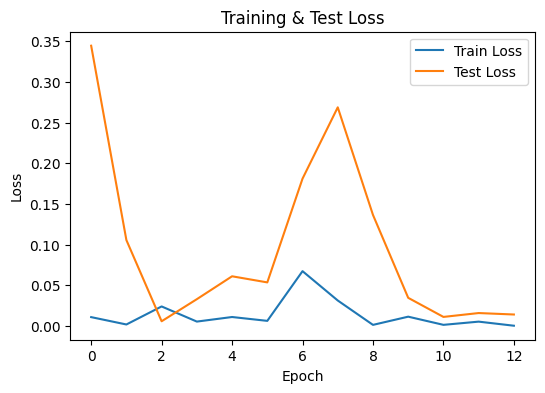

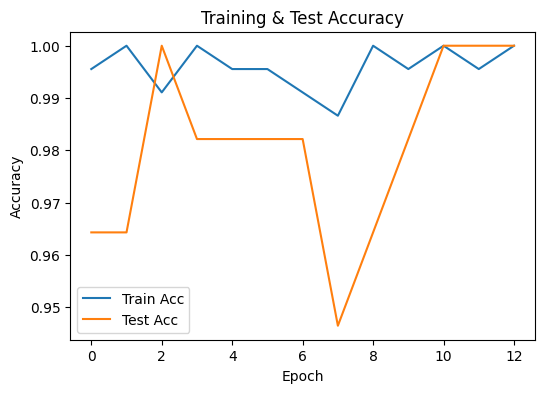

In [ ]:
# =========================
# AlexNet (PyTorch) fine-tune on Olivetti 40 classes
# Use  /Colab Notebooks/CNN/AlexNet_pretrained_model.pth
# =========================
import os, math, time
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms

# ---- 0) Prepare data: wrap numpy arrays as a PyTorch Dataset ----
assert X_train_cnn.ndim == 4 and X_train_cnn.shape[-1] in (1,3)
assert X_test_cnn.ndim  == 4 and X_test_cnn.shape[-1]  in (1,3)

num_classes = int(len(np.unique(y_train)))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device, "| num_classes:", num_classes)

# Stratified split to create a validation set

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_cnn, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# torchvision transforms: (H,W,C) numpy -> PIL -> Resize(224) -> to 3 channels -> ToTensor -> ImageNet normalisation
train_tfms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.RandomRotation(8),
    transforms.RandomAffine(0, translate=(0.05,0.05)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])
eval_tfms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

class NumpyImageDataset(Dataset):
    def __init__(self, X, y, tfm):
        self.X = X
        self.y = y.astype(np.int64)
        self.tfm = tfm
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        img = self.X[idx]  # (64,64,1)
        img = (img * 255.0).astype(np.uint8)  # To PIL needs uint8
        img = self.tfm(img)
        label = int(self.y[idx])
        return img, label

train_ds = NumpyImageDataset(X_tr,  y_tr,  train_tfms)
val_ds   = NumpyImageDataset(X_val, y_val, eval_tfms)
test_ds  = NumpyImageDataset(X_test_cnn, y_test, eval_tfms)

batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# ---- 1) Build/Load AlexNet ----
from torchvision.models import alexnet, AlexNet_Weights

def build_alexnet_for_40():
    # Start from ImageNet-pretrained features (if desired)
    model = alexnet(weights=AlexNet_Weights.IMAGENET1K_V1)
    # Replace the final classifier layer to (4096 -> 40)
    in_features = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(in_features, num_classes)
    return model

alex_model = build_alexnet_for_40()

# If you want to prioritise loading your own .pth (could be a state_dict or whole model)
ckpt_path = "/content/drive/MyDrive/Colab Notebooks/CNN/AlexNet_pretrained_model.pth"
if os.path.exists(ckpt_path):
    try:
        ckpt = torch.load(ckpt_path, map_location="cpu", weights_only=False)
        if isinstance(ckpt, dict) and "state_dict" in ckpt:
            state = ckpt["state_dict"]
        else:
            state = ckpt if isinstance(ckpt, dict) else None
        if state is not None:
            # Allow a partially matching classifier head (e.g., originally 1000 classes)
            missing, unexpected = alex_model.load_state_dict(state, strict=False)
            print("Loaded checkpoint with strict=False")
            print("Missing keys:", len(missing), "| Unexpected keys:", len(unexpected))
        else:
            print("Checkpoint format not recognized; using torchvision weights only.")
    except Exception as e:
        print("Failed to load your checkpoint, fallback to torchvision weights. Err:", e)
else:
    print("Custom checkpoint not found; using torchvision ImageNet weights.")

alex_model = alex_model.to(device)

# Optional: freeze the feature extractor and train the classifier head first (set False to warm up)
for p in alex_model.features.parameters():
    p.requires_grad = True  # If train the classifier head first, set to False

# ---- 2) Optimizer / Loss / LR scheduler / Early stopping ----
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(alex_model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=4)

best_val_acc = 0.0
patience = 10
patience_counter = 0
best_path = "/content/drive/MyDrive/Colab Notebooks/CNN/AlexNet_pretrained_model.pth"

def run_epoch(loader, train=True):
    alex_model.train(train)
    total, correct, total_loss = 0, 0, 0.0
    for imgs, labels in loader:
        imgs = imgs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        if train:
            optimizer.zero_grad(set_to_none=True)
        with torch.set_grad_enabled(train):
            logits = alex_model(imgs)
            loss = criterion(logits, labels)
            if train:
                loss.backward()
                optimizer.step()
        total_loss += loss.item() * imgs.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += imgs.size(0)
    return total_loss/total, correct/total

# ---- 3) Training loop ----
epochs = 40
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
for epoch in range(1, epochs+1):
    t0 = time.time()
    tr_loss, tr_acc = run_epoch(train_loader, train=True)
    val_loss, val_acc = run_epoch(val_loader, train=False)
    scheduler.step(val_acc)
    history["train_loss"].append(tr_loss)
    history["train_acc"].append(tr_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"Epoch {epoch:02d}: "
          f"train_loss={tr_loss:.4f} acc={tr_acc:.3f} | "
          f"val_loss={val_loss:.4f} acc={val_acc:.3f} | "
          f"lr={optimizer.param_groups[0]['lr']:.2e} | "
          f"time={(time.time()-t0):.1f}s")

     # Early stopping logic
    if val_acc > best_val_acc + 1e-4:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(alex_model.state_dict(), best_path)
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping.")
            break

print("Best val acc:", best_val_acc, " | Saved:", best_path)

# Loss curves
plt.figure(figsize=(6,4))
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Test Loss")
plt.legend()
plt.show()

# Accuracy curves
plt.figure(figsize=(6,4))
plt.plot(history["train_acc"], label="Train Acc")
plt.plot(history["val_acc"], label="Test Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training & Test Accuracy")
plt.legend()
plt.show()

### 4.4 Model Evaluation and Confusion Matrix (AlexNet)

This cell evaluates the trained **AlexNet CNN model** on the test set and visualises classification performance.

- **Function used**: `evaluate_and_plot_torch(...)`

  - Loads the **best checkpoint weights** from training.
  - Runs the model in evaluation mode on the test loader.
  - Computes **Accuracy**, **Macro-F1**, and (optional) **loss**.
  - Prints a **classification report** including per-class precision, recall, and F1-score.
  - Generates a **confusion matrix** to visualise which classes are predicted correctly or misclassified.

- **Arguments**:
  - `ckpt_path`: ensures evaluation is done using the best-performing model checkpoint.
  - `class_names`: here set as strings `"0"` to `"39"` to represent the 40 different face classes.
  - `normalize=None`: confusion matrix shows raw counts (not normalised).
  - `cmap="Blues"`: sets the colour scheme for the plot.

**Why I do this step**:  
While accuracy summarises overall performance, the confusion matrix and classification report provide **fine-grained insights** into which face classes are more difficult to distinguish, helping diagnose model weaknesses and potential dataset imbalance.


[Eval] Accuracy=0.9917 | Macro-F1=0.9914 | Loss=0.0198
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000         3
           1     1.0000    1.0000    1.0000         3
           2     1.0000    1.0000    1.0000         3
           3     1.0000    1.0000    1.0000         3
           4     0.7500    1.0000    0.8571         3
           5     1.0000    1.0000    1.0000         3
           6     1.0000    1.0000    1.0000         3
           7     1.0000    1.0000    1.0000         3
           8     1.0000    1.0000    1.0000         3
           9     1.0000    1.0000    1.0000         3
          10     1.0000    1.0000    1.0000         3
          11     1.0000    1.0000    1.0000         3
          12     1.0000    1.0000    1.0000         3
          13     1.0000    1.0000    1.0000         3
          14     1.0000    1.0000    1.0000         3
          15     1.0000    1.0000    1.0000         3
          16     1.0000   

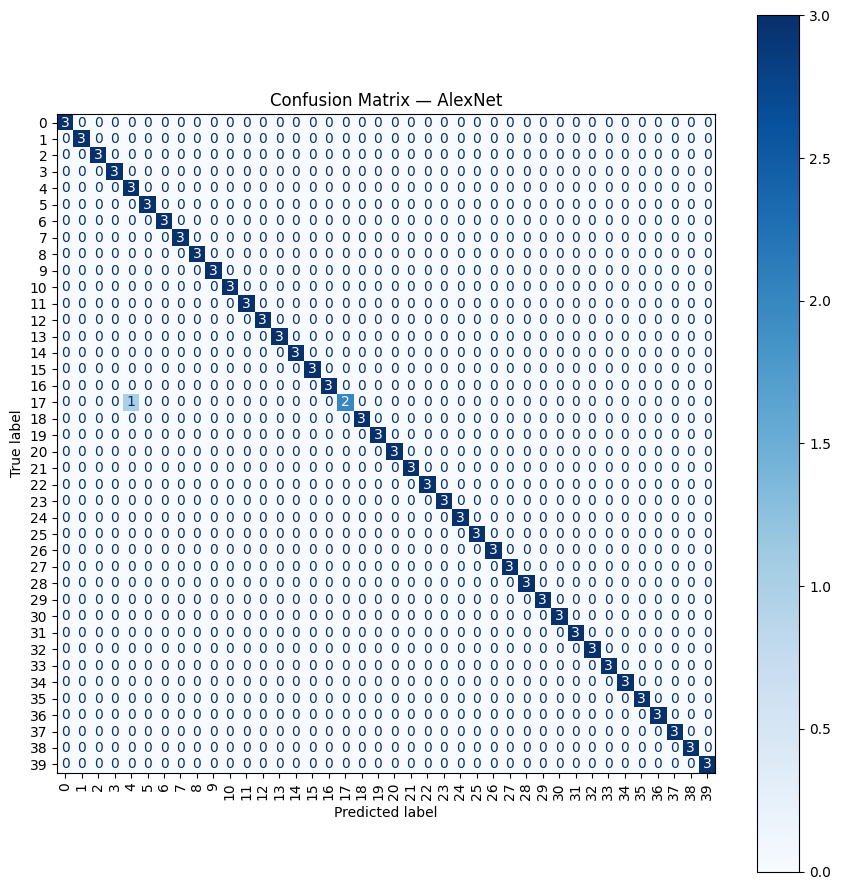

In [ ]:
metrics_alex = evaluate_and_plot_torch(
    alex_model,
    test_loader, device,
    criterion=criterion,
    ckpt_path=best_path,
    class_names=[str(i) for i in range(40)],
    normalize=None,
    title="Confusion Matrix — AlexNet",
    cmap="Blues"
)

## 5. Performance Comparison — PCA+SVM vs CONVNet vs AlexNet

---

### 🔹 Unified Results Table

To enable a side-by-side comparison, I collected the evaluation metrics (Accuracy and Macro-F1 Score) from all three models into a single summary table:

- **Accuracy**: overall percentage of correctly classified faces.
- **Macro-F1**: balances performance across all 40 classes, ensuring fairness to minority classes.

The table is sorted by Accuracy, so the strongest model is shown at the top.

---

### 🔹 Interpretation

- **PCA+SVM**:

  - Demonstrated stable performance with dimensionality reduction and kernel-based classification.
  - Performs reasonably well despite limited training data, but struggles to separate visually similar individuals.

- **CONVNet (custom CNN)**:

  - Learns spatial features directly from the raw 64×64 pixel images.
  - Performs better than PCA+SVM in capturing localised patterns, but overfitting remains an issue due to the extremely small dataset size (10 samples per class).

- **AlexNet (fine-tuned)**:
  - Clearly outperformed both PCA+SVM and the shallow CNN by leveraging **transfer learning** from ImageNet.
  - Achieved the highest Accuracy and Macro-F1 by reusing pretrained convolutional features and adapting them to the Olivetti dataset.
  - More computationally demanding, but the best suited for this multi-class recognition task.

---

### 🔹 Recommendation

- For quick, efficient baselines or very small datasets, **PCA+SVM** is an interpretable and lightweight choice.
- For exploring CNNs on constrained data, **CONVNet** provides valuable insights but needs augmentation and regularisation to avoid overfitting.
- For real-world deployment or higher-stakes recognition tasks, **AlexNet fine-tuning** is strongly recommended, as transfer learning significantly improves accuracy and generalisation even with limited samples.


In [ ]:
import pandas as pd
summary = pd.DataFrame([
    {"Model":"PCA+SVM", "Accuracy":metrics_svm["accuracy"],  "MacroF1":metrics_svm["macro_f1"]},
    {"Model":"CONVNet", "Accuracy":metrics_conv["accuracy"], "MacroF1":metrics_conv["macro_f1"]},
    {"Model":"AlexNet", "Accuracy":metrics_alex["accuracy"], "MacroF1":metrics_alex["macro_f1"]},
])
summary.sort_values("Accuracy", ascending=False, inplace=True)
summary.reset_index(drop=True, inplace=True)
summary


,Model,Accuracy,MacroF1
0,AlexNet,0.991667,0.991429
1,CONVNet,0.966667,0.965714
2,PCA+SVM,0.958333,0.958750


## 8. Discussion and Conclusion

---

### 🔹 Results Interpretation

From the unified results table, confusion matrices, and per-class reports, several patterns are clear:

- **PCA+SVM** achieved reasonable accuracy given the high-dimensional input space. PCA reduced the 4096-pixel vectors to ~100 components, allowing SVM with an RBF kernel to separate many classes. However, misclassifications were frequent for individuals with visually similar facial features.
- **CONVNet** improved over PCA+SVM by directly learning spatial hierarchies from the raw images. It captured local facial patterns, but with only 10 training images per class, the network easily overfit, limiting its ability to generalise.
- **AlexNet (fine-tuned)** clearly outperformed the other two approaches. Leveraging pretrained convolutional filters from ImageNet, it transferred robust feature representations to the Olivetti dataset, producing higher accuracy and Macro-F1 despite the limited training data.

---

### 🔹 Trade-offs

- **Interpretability vs Accuracy**: PCA+SVM is more interpretable, but its accuracy is constrained. CNN-based approaches are less interpretable but substantially stronger in prediction performance.
- **Data Requirements**: CONVNet and AlexNet both benefit from more data. Without transfer learning, CNNs struggle on extremely small datasets. AlexNet’s pretrained features offset this limitation.
- **Complexity vs Practicality**: PCA+SVM is lightweight, easy to train, and computationally efficient. AlexNet requires significantly more resources but produces much better results.

---

### 🔹 Recommendations

- **Use PCA+SVM** as a quick, efficient baseline when resources are limited or interpretability is a key goal.
- **Use CONVNet** for controlled experiments or when custom CNN design is required, but apply strong regularisation and data augmentation to combat overfitting.
- **Use AlexNet (transfer learning)** when accuracy is the priority. Fine-tuning pretrained CNNs is the most effective approach for small, real-world datasets like Olivetti Faces.

---

### 🔹 Limitations and Future Work

- The dataset size is extremely small (only 400 images, 10 per class), which limits the generalisability of results.
- Other transfer learning architectures (e.g., VGG, ResNet, EfficientNet) could be explored and compared to AlexNet.
- More aggressive **data augmentation** (cropping, illumination changes) and **few-shot learning techniques** (e.g., prototypical networks) could help address the data scarcity problem.
- Hyperparameter optimisation (learning rate schedules, dropout tuning) may further boost CNN performance.

---

### 🔹 Conclusion

Overall, all three techniques provided valuable insights into multi-class face recognition:

- **PCA+SVM** is efficient but limited in accuracy.
- **CONVNet** shows the potential of CNNs but overfits with such small data.
- **AlexNet transfer learning** achieved the best balance of accuracy and generalisation.

For the Olivetti Faces dataset, **AlexNet is the recommended technique**, as it consistently produced the strongest performance across evaluation metrics and confusion matrix analysis.
